<a href="https://colab.research.google.com/github/RayNCode/code_collab/blob/main/LogisticRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
import xgboost as xgb
from xgboost import XGBClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import sklearn
sklearn.set_config(display="diagram")
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from itertools import combinations
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor

**Data Preprocessing**

In [ ]:
data_url = "https://raw.githubusercontent.com/RayNCode/code_collab/main/project-3-files"
learn_dataset = pd.read_csv(f"{data_url}/learn_dataset.csv").copy()
learn_dataset_Emp_contract = pd.read_csv(f"{data_url}/learn_dataset_Emp_contract.csv").copy()
learn_dataset_sport = pd.read_csv(f"{data_url}/learn_dataset_sport.csv").copy()
learn_dataset_job = pd.read_csv(f"{data_url}/learn_dataset_job.csv").copy()

code_work_description_map = pd.read_csv(f"{data_url}/code_work_description_map.csv").copy()
city_adm = pd.read_csv(f"{data_url}/city_adm.csv").copy()
code_Club = pd.read_csv(f"{data_url}/code_Club.csv").copy()
departments = pd.read_csv(f"{data_url}/departments.csv").copy()

test_dataset_job = pd.read_csv(f"{data_url}/test_dataset_job.csv").copy()
test_dataset = pd.read_csv(f"{data_url}/test_dataset.csv").copy()
test_dataset_Emp_contract = pd.read_csv(f"{data_url}/test_dataset_Emp_contract.csv").copy()
test_dataset_sport = pd.read_csv(f"{data_url}/test_dataset_sport.csv").copy()

In [ ]:
def preprocess_data_base(learn_dataset_job, work_desc, learn_dataset, dept_code, emp_contract, learn_dataset_sport, code_club, departments):
    # Chargement et fusion des datasets de travail
    merged_df = pd.merge(learn_dataset_job, work_desc, left_on='work_description', right_on='N3', how='left')

    # Conversion des colonnes N2, N1 et N3 en chaînes de caractères
    merged_df['N2'] = merged_df['N2'].astype(str)
    merged_df['N1'] = merged_df['N1'].astype(str)
    merged_df['N3'] = merged_df['N3'].astype(str)

    # Remplir les valeurs manquantes
    merged_df['N2'].fillna(merged_df['N3'].str[:-2], inplace=True)
    merged_df['N1'].fillna(merged_df['N2'].str[:-1], inplace=True)

    # Fusion avec d'autres datasets
    data_2 = pd.merge(learn_dataset, merged_df, on="Id", how="left")
    df_1 = data_2.merge(dept_code, on='insee_code')
    df_2 = df_1.merge(emp_contract, on='Id', how='left')
    df_3 = df_2.merge(learn_dataset_sport, on='Id', how='left')
    df_4 = df_3.merge(code_Club, left_on='Club', right_on='Code', how='left')
    final_df = df_4.merge(departments, on='dep', how='left')

    # Conversion de type pour les colonnes 'Categorie' et 'REG'
    final_df['Categorie'] = final_df['Categorie'].astype(str).astype('object')
    final_df['REG'] = final_df['REG'].astype(str).astype('object')


    # Création et application d'une condition pour filtrer et imputer des valeurs
    condition = (final_df['ACTIVITY_TYPE'] != "TYPE1|1")
    final_df.loc[condition, ['EMOLUMENT', 'Working_hours']] = 0.0
    # Traitement des valeurs manquantes dans les colonnes catégorielles
    categorical_columns = final_df.select_dtypes(include=['object']).columns
    final_df[categorical_columns] = final_df[categorical_columns].fillna("None")


    return final_df

In [ ]:
learn_dataset_base = preprocess_data_base(learn_dataset_job, code_work_description_map, learn_dataset, city_adm, learn_dataset_Emp_contract, learn_dataset_sport, code_Club, departments)
test_dataset_base = preprocess_data_base(test_dataset_job, code_work_description_map, test_dataset, city_adm, test_dataset_Emp_contract, test_dataset_sport, code_Club,departments)

In [ ]:
def preprocess_learn_test(final_df): #ajouter l'ID quelque part
    # Séparer la variable cible si elle est présente
    if 'target' in final_df.columns:
        y = final_df['target'].copy()
        y = np.where(y == 'B', 1, 0)
        X = final_df.drop(['target'], axis='columns')
    else:
        X = final_df.copy()
        X_test_id = X['Id'].copy()

    # Suppression des colonnes non nécessaires
    X = X.drop(["Id", 'Nom de la commune', 'Nom fédération', 'Nom catégorie', 'Nom du département', 'Code'], axis="columns")


    # Imputation des valeurs manquantes - Ce n'est certainement pas la façon la plus efficiente de le faire. À voir si l'on change.
    imputer = IterativeImputer(estimator=RandomForestRegressor(), max_iter=50, random_state=0)
    columns_to_impute = ['Working_hours', 'EMOLUMENT']
    X[columns_to_impute] = imputer.fit_transform(X[columns_to_impute])


    if 'target' in final_df.columns:
      return X, y
    else:
      return X, X_test_id

In [ ]:
X, y = preprocess_learn_test(learn_dataset_base)
X_test, X_test_id = preprocess_learn_test(test_dataset_base)
print("Shape de X_train:", X.shape)
print("Shape de y_test:", y.shape)
print("Shape de X_test:", X_test.shape)

/usr/local/lib/python3.10/dist-packages/sklearn/impute/_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


Shape de X_train: (49993, 27)
Shape de y_test: (49993,)
Shape de X_test: (49992, 27)


/usr/local/lib/python3.10/dist-packages/sklearn/impute/_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [ ]:
preprocessing = make_column_transformer (
    (OneHotEncoder(handle_unknown='ignore'), ['insee_code',"is_student", "OCCUPATION_42", "ACTIVITY_TYPE", "household", "sex", "employer_category", "job_category", "Terms_of_emp",
                       "Eco_sect", "Job_dep", "WORK_CONDITION", "work_description","N3", "N2", "N1", "town_type", "dep", "Emp_contract", "Club", "Categorie", 'REG']),
    (OrdinalEncoder(), ["Highest_degree", "EMPLOYEE_COUNT"]),
    remainder='passthrough')

**Hyperparameter Tuning**

In [ ]:
param_grid = {
    'logreg__penalty': ['l2'],  # 'l1' penalty is not compatible with 'newton-cg'
    'logreg__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'logreg__solver': ['newton-cg'],  # Only 'newton-cg' is directly compatible with multinomial
    'logreg__max_iter': [100, 200, 300], # check with increasing for best results, I started with 50, it took 3 hours to run.
    'logreg__class_weight': [None, 'balanced'],
    'logreg__fit_intercept': [True, False],
    'logreg__intercept_scaling': [1, 2, 5],
    'logreg__dual': [False],  # Dual should be False for 'newton-cg'
    'logreg__multi_class': ['multinomial'],
}

In [ ]:
##Hyperparameter Tuning for Logistic regression

def tune_hyperparameters(X_train, y_train):
  logreg = LogisticRegression(random_state = 42)


  pipeline = Pipeline(steps=[('preprocessing', preprocessing),
                             ('logreg', logreg)])

  cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

  #RandomizedSearchCV object
  logreg_grid = RandomizedSearchCV(
      estimator=pipeline,
      param_distributions=param_grid,
      cv=cv,
      scoring='accuracy',
      n_iter=50,
      n_jobs=-1,
      random_state=0
    )

  logreg_grid.fit(X_train, y_train)

  print("Best hyperparameters:\n", logreg_grid.best_params_)

  return logreg_grid.best_estimator_

In [ ]:
logreg_opt = tune_hyperparameters(X_train, y_train)

Best hyperparameters:
 {'logreg__solver': 'newton-cg', 'logreg__penalty': 'l2', 'logreg__multi_class': 'multinomial', 'logreg__max_iter': 200, 'logreg__intercept_scaling': 1, 'logreg__fit_intercept': False, 'logreg__dual': False, 'logreg__class_weight': None, 'logreg__C': 1}


In [ ]:
##Metrics calculator for logistic regression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def logistic_regression_metrics_calculator(logreg, X_test, y_test, model_name):

    y_pred = logreg.predict(X_test)
    y_pred_proba = logreg.predict_proba(X_test)[:, 1]

    result = pd.DataFrame(data=[
        accuracy_score(y_test, y_pred),
        precision_score(y_test, y_pred, average='macro'),
        recall_score(y_test, y_pred, average='macro'),
        f1_score(y_test, y_pred, average='macro'),
        roc_auc_score(y_test, y_pred_proba, average='macro')],
        index=['Accuracy', 'Macro Precision', 'Macro Recall', 'Macro F1-score', 'Macro AUC'],
        columns=[model_name])

    result = (result * 100).round(2).astype(str) + '%'
    return result


In [ ]:
def logistic_regression_evaluation(logreg, X_train, X_test, y_train, y_test, model_name):
    '''
    This function provides a complete report of the logistic regression model's performance
    including classification reports and confusion matrix.
    '''
    # Set font scale
    sns.set(font_scale=1.5)

    # Generate classification report for training set
    y_pred_train = logreg_opt.predict(X_train)
    print("\n\t  Classification report for training set")
    print("-" * 55)
    print(classification_report(y_train, y_pred_train))

    # Generate classification report for test set
    y_pred_test = logreg_opt.predict(X_test)
    print("\n\t   Classification report for test set")
    print("-" * 55)
    print(classification_report(y_test, y_pred_test))
    print('\n')

    # Create figure and subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, dpi=90, figsize=(12, 5))

    # Plot confusion matrix for test set
    cmap = plt.cm.Purples
    ConfusionMatrixDisplay.from_estimator(logreg, X_test, y_test, colorbar=False, cmap=cmap, ax=ax1)
    ax1.set_title('Confusion Matrix for Test Data')
    ax1.grid(False)

    # Report desired results as a summary in the form of a table
    result = logistic_regression_metrics_calculator(logreg_opt, X_test, y_test, model_name)
    table = ax2.table(cellText=result.values, colLabels=result.columns, rowLabels=result.index, loc='center')
    table.scale(0.6, 3.6)
    table.set_fontsize(12)
    ax2.axis('tight')
    # Hide the axes
    ax2.axis('off')
    # set the title
    ax2.set_title('{} Performance Summary on Test Data'.format(model_name), fontsize=18)
    # Modify color
    for key, cell in table.get_celld().items():
        if key[0] == 0:
            cell.set_color('purple')

    plt.tight_layout()
    plt.show()



	  Classification report for training set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.92      0.90      0.91     15412
           1       0.94      0.95      0.95     24582

    accuracy                           0.93     39994
   macro avg       0.93      0.93      0.93     39994
weighted avg       0.93      0.93      0.93     39994


	   Classification report for test set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.85      0.85      0.85      3853
           1       0.90      0.91      0.91      6146

    accuracy                           0.88      9999
   macro avg       0.88      0.88      0.88      9999
weighted avg       0.88      0.88      0.88      9999





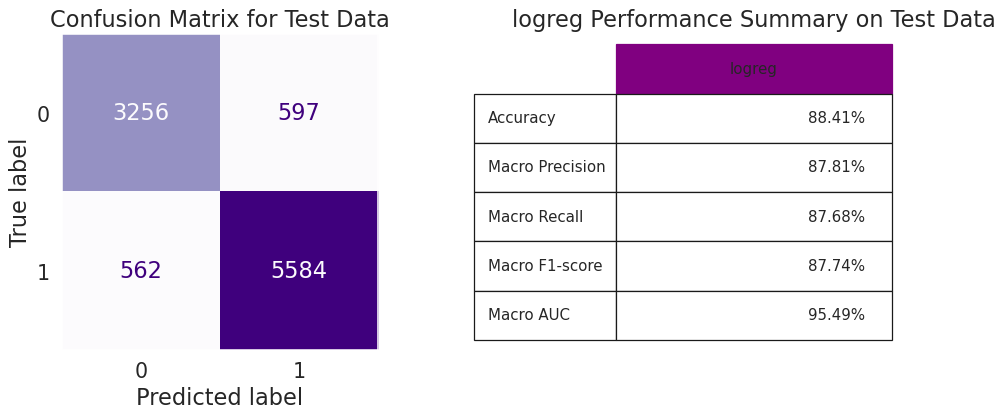

In [ ]:
logistic_regression_evaluation(logreg_opt, X_train, X_test, y_train, y_test, 'logreg')